# Dependencies

In [1]:
import MURA
import cv2
import image_manipulation
from multiprocessing import Pool
from models import *
import numpy as np
import glob
import matplotlib.pyplot as plt
import preprocessing
import json
from os import path, mkdir
import re
from PIL import Image

import keras
from argparse import ArgumentParser
import tensorflow as tf
from sklearn import metrics

c:\Users\SKill\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13066513445374030859
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5718933504
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11350026772920077428
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2d:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


# Model to Run
This section lets the user edit on what model parameters to run, the model directory and parameters should exist prior to changing the file path

In [3]:
# All editable variables
model_file_path = "models/UPAE/dataset_1"

In [4]:
# Get model parameters
try:
    params = json.load(open(model_file_path + '/parameters.json'))

    # Model to use
    model_is_VAE = params['is_VAE']
    # Model parameters
    multiplier = params['multiplier']
    latent_size = params['latent_size']
    input_shape = params['input_shape']

    # Training parameters
    epochs = params['num_epochs']
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']

    # Dataset Path
    dataset_file_path = params['dataset_path']

except:
    raise Exception("No parameters.json file found in the model's directory.")

In [5]:
# each array contains the training, validation, and testing in order
image_datasets = {'train': [], 'test': [], 'valid': []}
for dataset_name in image_datasets.keys():
    for image_path in glob.glob(f'{dataset_file_path}/{dataset_name}/*.png'):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_datasets[dataset_name].append(image)
    image_datasets[dataset_name] = np.array(image_datasets[dataset_name])

# Model Training
This section creates and trains the model

In [6]:
if __name__ == "__main__":

    if model_is_VAE:
        model = VAE(False, input_shape, multiplier, latent_size)
    else:
        model = UPAE(True, input_shape, multiplier, latent_size)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.build(input_shape=(None,) + tuple(input_shape))

    model.compile(optimizer= optimizer, loss='mse'
                  ,metrics=[tf.keras.metrics.Accuracy()])
    
    model.summary()
    
    try:
        model.load_weights(model_file_path + "/model_weights")
    except:
        train_data = image_datasets['train']
        validation_data = image_datasets['valid']

        # Where images of each epoch will be saved
        save_directory = model_file_path + '/callback_images'
        save_callback = SaveImageCallback(validation_data, save_directory=save_directory, vae=model_is_VAE)

        EarlyStopping_callback = tf.keras.callbacks.EarlyStopping(monitor='mse_loss', patience=30,
                                                                  restore_best_weights=True)

        history_train = model.fit(train_data, 
                                epochs=epochs, 
                                batch_size=batch_size,
                                validation_data=(validation_data, validation_data),
                                callbacks=[save_callback, EarlyStopping_callback])
        
        # Saving the model's history
        json.dump(history_train.history, open(model_file_path + '/history.json', 'w'))

        #Save weights
        model.save_weights(model_file_path + '/model_weights')
   
    

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 16, 16, 128)   

c:\Users\SKill\anaconda3\envs\DL\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "upae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_decoder (encoder_de  multiple                 19695232  
 coder)                                                          
                                                                 
Total params: 19,695,244
Trainable params: 19,684,736
Non-trainable params: 10,508
_________________________________________________________________
Epoch 1/300
59/59 [==============================] - 4s 26ms/step - mse_loss: 9962.3115 - total_loss: 174.5236 - loss1: 116.0269 - loss2: 58.4968 - reconstruction_loss: -393.2376 - accuracy: 0.0544 - val_mse_loss: 2410.0642 - val_total_loss: 13.1926 - val_loss1: 1.2545 - val_loss2: 11.9381 - val_reconstruction_loss: -477.6607 - val_accuracy: 0.0143
Epoch 2/300
59/59 [==============================] - 1s 15ms/step - mse_loss: 3035.2791 - total_loss: 14.7017 - loss1: 2.3566 - loss2: 12.3451 - reconstruct

# Creating of different Plots

In [7]:
# Create directory for saving images
save_directory = model_file_path + '/plots'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)


In [8]:
# Get history of data
history = history_train.history

def create_plot(history, metric, title, save_name):
    plt.plot(history[metric], label=metric)
    plt.plot(history[f'val_{metric}'], label=f'val_{metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(title)
    plt.legend()
    plt.savefig(f'{save_directory}/{save_name}', dpi=300)
    plt.close()

# Check if UPAE or not
if model_is_VAE:
    # Create plot for mse_loss
    create_plot(history, 'mse_loss', 'MSE Loss per Epoch', 'mse_loss.png')
    # Create plot for reconstruction_loss
    create_plot(history, 'reconstruction_loss', 'Reconstruction Loss per Epoch', 'reconstruction_loss.png')
    # Create plot for kl_loss
    create_plot(history, 'kl_loss', 'KL Loss per Epoch', 'kl_loss.png')
else:
    # Create plot for mse_loss
    create_plot(history, 'mse_loss', 'MSE Loss per Epoch', 'mse_loss.png')
    # Create plot for total loss
    create_plot(history, 'total_loss', 'Total Loss per Epoch', 'total_loss.png')
    # Create plot for loss1
    create_plot(history, 'loss1', 'Loss 1 per Epoch', 'loss1.png')
    # Create plot for loss2
    create_plot(history, 'loss2', 'Loss 2 per Epoch', 'loss2.png')
    # Create plot for binary_crossentropy
#     create_plot(history, 'reconstruction_loss', 'Reconstruction Loss per Epoch', 'reconstruction_loss.png')
#     # Create plot for accuracy
#     create_plot(history, 'accuracy', 'Accuracy per Epoch', 'accuracy.png')
    

# Testing of the Model with the Test Set
This section tests the model with the current test set
TODO: 
- Get the label of each image in the test set
- Test the images
- Create Linear Regression for the abnormality score to get the threshold for determining abnormal or normal images

In [9]:
# Get labels of each image in the image_datasets['test']
test_images = []
labels = []
for image_path in glob.glob(f'{dataset_file_path}/test/*.png'):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Get if it contains positive or negative
    if 'positive' in image_path:
        test_images.append(image)
        labels.append(1)
    else:
        test_images.append(image)
        labels.append(0)
test_images = np.array(test_images)

In [10]:
history_valid = model.predict(image_datasets['test'], batch_size=batch_size)

In [21]:
abnor_scores = history_valid[2]
#converting to an array of numbers instead of tensor
abnor_scores = [item.numpy() for item in abnor_scores if isinstance(item, tf.Tensor)]
abnor_scores = [float(item) for item in abnor_scores]

In [28]:
auc = metrics.roc_auc_score(labels, abnor_scores)
fpr, tpr, thresholds = metrics.roc_curve(labels, abnor_scores)

In [33]:
#Getting roc_curve output
fpr, tpr, thresholds = metrics.roc_curve(labels, abnor_scores)
idx = None

#Computation for the threshold
lowest = 1 - tpr[0]
lowest = abs(fpr[0] - lowest)
for i in range(len(fpr)):
    fnr = 1 - tpr[i]
    curr_value = abs(fpr[i] - fnr)
    if curr_value < lowest:
        idx = i
        break
assert idx is not None
t = thresholds[idx]

In [34]:
#using threshold t , will be used to classify abnormality scores as normal or abnormal in the y_pred array;
y_pred = np.zeros_like(labels)
y_pred[abnor_scores < t] = 0
y_pred[abnor_scores >= t] = 1


# getting metrics score using y_pred which is now either 0  or 1
pres = metrics.precision_score(labels, y_pred)
sens = metrics.recall_score(labels, y_pred, pos_label=1)
spec = metrics.recall_score(labels, y_pred, pos_label=0)
f1 = metrics.f1_score(labels, y_pred)
print('Error rate:{}'.format(fpr[idx]))
print('Precision:{} \nSensitivity:{} \nSpecificity:{} \nf1:{}\n'.format(
     pres, sens, spec, f1))

Error rate:0.01098901098901099
Precision:0.0 
Sensitivity:0.0 
Specificity:0.989010989010989 
f1:0.0



# Creating Plot for abnormality scores of normal and abnormal images

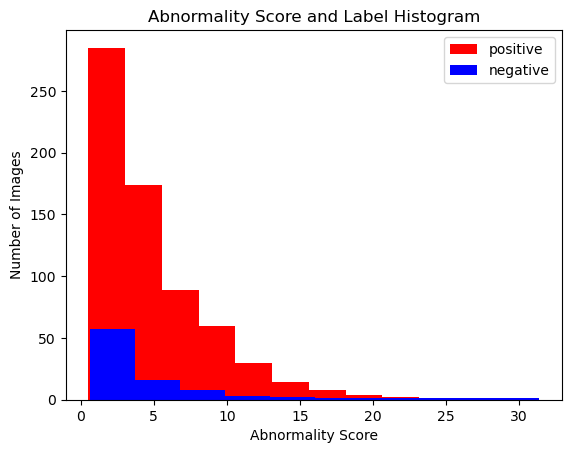

In [59]:
# Histogram for Positives and Negatives of the testing set
positive = []
negative = []
for i in range(len(labels)):
    if labels[i] == 1:
        positive.append(abnor_scores[i])
    else:
        negative.append(abnor_scores[i])
plt.hist(positive, color='red', label='positive')
plt.hist(negative, color='blue', label='negative')
# Get x and y labels
plt.xlabel('Abnormality Score')
plt.ylabel('Number of Images')
plt.title("Abnormality Score and Correct Label Histogram")
plt.legend()
plt.savefig(f'{save_directory}/testing_abnormality_scores.png')

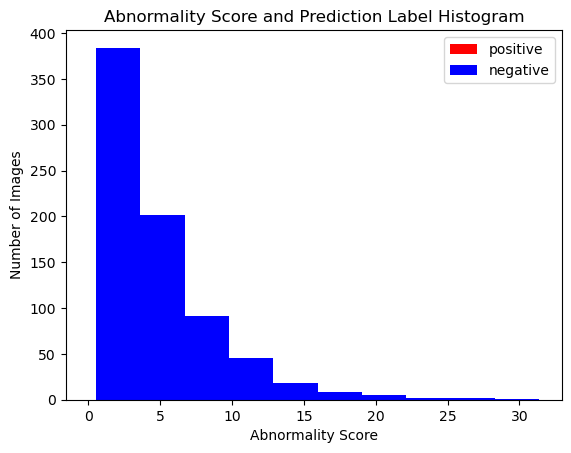

In [61]:
positive = []
negative = []
for i in range(len(labels)):
    if abnor_scores[i] == 1:
        positive.append(abnor_scores[i])
    else:
        negative.append(abnor_scores[i])
plt.hist(positive, color='red', label='positive')
plt.hist(negative, color='blue', label='negative')
# Get x and y labels
plt.xlabel('Abnormality Score')
plt.ylabel('Number of Images')
plt.title("Abnormality Score and Prediction Label Histogram")
plt.legend()
plt.savefig(f'{save_directory}/testing_abnormality_scores_prediction.png')

# Saving of final reconstructed images 

In [35]:
# Create directory in models folder for reconstructed images
dataset_name = dataset_file_path.split('/')[-1]
reconstructed_images_path = model_file_path + "/" + dataset_name
if not path.exists(reconstructed_images_path):
    mkdir(reconstructed_images_path)

In [53]:
def save_compared_reconstructed_image(original_image, reconstructed_image, abnormality_score, file_path, image_index,
                                      label, variance = None):
    # Put Images in cv2
    original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)
    reconstructed_image = cv2.cvtColor(reconstructed_image, cv2.COLOR_GRAY2BGR)
    # Convert reconstructed image to uint8
    reconstructed_image = reconstructed_image.astype(np.uint8)
    if variance is not None:
        variance_image = cv2.cvtColor(variance, cv2.COLOR_GRAY2BGR)
        concatenated_img = cv2.hconcat([original_image, reconstructed_image, variance_image])
    else:
        concatenated_img = cv2.hconcat([original_image, reconstructed_image])
    # Save the image
    cv2.imwrite(f'{file_path}/Image_{image_index}_{abnormality_score}_{label}.png', concatenated_img)

In [54]:
for i in range(len(test_images)):
    if model_is_VAE:
        save_compared_reconstructed_image(test_images[i], np.array(history_valid[0][i]), history_valid[2][i],
                                      reconstructed_images_path, i, labels[i])
    else:
        save_compared_reconstructed_image(test_images[i], np.array(history_valid[0][i]), history_valid[2][i],
                                      reconstructed_images_path, i, labels[i],  np.array(history_valid[1][i]))


# GIF for Callback_images

In [55]:
def extract_epoch(filename):
    match = re.search(r'epoch_(\d+)', filename)
    if match:
        return int(match.group(1))
    return 0

def create_gif(folder_path, output_path, duration=50):
    images = []
    
    # Get all image file names from the folder
    filenames = os.listdir(folder_path)
    filenames = sorted(filenames, key=lambda x: extract_epoch(x))

    for filename in filenames:
        if filename.endswith('.png') or filename.endswith('.jpg'):
            file_path = os.path.join(folder_path, filename)
            image = Image.open(file_path).convert('P')
            images.append(image)
    
    # Save the images as a GIF
    images[0].save(output_path, save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=0)


In [56]:
gif_folder_path = model_file_path + "/" + "callback_images"
image_folders = ['image0', 'image1', 'image2']

for i,folder in enumerate(image_folders):
    curr_folder = gif_folder_path + "/" + folder
    gif_output_path = gif_folder_path + "/" + f"image{i}.gif"
    print(f"Creating GIF for: image{i}")
    create_gif(curr_folder, gif_output_path)

Creating GIF for: image0
Creating GIF for: image1
Creating GIF for: image2
